In [1]:
import random

from environment import Environment
from agent import Agent
import pickle

def random_agent_performance(secret='1234'):
    '''return num of guesses needed to get secret for an random agent'''
    random_agent = Agent()
    random_agent.reset_possible_states()
    guess = random_agent.get_best_action()
    env = Environment(secret)
    num_guess = 1
    while guess!= secret:
        random_agent.possible_states.remove(guess)
        guess = random_agent.get_best_action()
        num_guess += 1
    return num_guess


def random_agent_average_performance(num):
    l = []
    for _ in range(num):
        secret = Environment._number_from_index(random.randint(0,9**4-1))
        length = random_agent_performance(secret)
        l.append(length)
    return sum(l)/len(l)


def train(agent, n_episodes):
    '''
    Train the agent for n_episodes.
    '''
    for _ in range(n_episodes):
        secret = Environment._number_from_index(random.randint(0,9**4-1))
        env = Environment(secret)
        agent.reset_possible_states()
        action = agent.random_action()  # init action
        
        if action == secret: # if init guess is crt skip this episode
            continue
            
        run = True
        while run:
            feedback = env.get_feedback(action)
            reward   = env.reward(action)
            agent.learn_from_move(action, feedback, reward)
            
            if action == secret:
                break  # correct guess stop episode
            else:
                action = agent.random_action()  # else next guess

                
def num_guesses(agent, secret='1234'):
    '''return number of guesses needed by the agent to
    get to the secret'''
    agent.reset_possible_states()
    guess = agent.get_best_action()
    env = Environment(secret)
    num_guess = 1
    while guess!= secret:
        feedback = env.score(secret, guess)
        agent.restrict_possible_states(guess, feedback)
        guess = agent.get_best_action()
        num_guess += 1
    return num_guess


def avg_num_guesses_needed(agent):
    '''average number guesses needed for all the possible secret codes'''
    
    nums = [] 
    
    for idx in range(9**4):
        secret = Environment._number_from_index(idx)
        length = num_guesses(agent, secret)
        nums.append(length)
        
#     print(nums)
    return sum(nums)/len(nums)
    6

def worst_case_length(agent):
    '''num of guesses needed in worst case'''
    
    nums = [] 
    
    for idx in range(9**4):
        secret = Environment._number_from_index(idx)
        length = num_guesses(agent, secret)
        nums.append(length)
        
#     print(nums)
    return max(nums)


## baseline performance

In [2]:
random_agent_average_performance(50)

5264.94

There are 1296 possibile patterns in the mastermind game. An agent which chooses a random action, takes around ~ **584** guesses to match the target secret code. This random agent does not take feedback into consideration.

> In 1977, Donald Knuth came up with a Five-guess algorithm which guesses the secret code with 5 guesses. 

Instead of using random agent, we will try use this Five-guess algorithm to compare the learning of our agent.

## Training Agent using Q-learning

### train for 2000 episodes

In [3]:
q_agent = Agent(epsilon=0.2)

In [4]:
train(q_agent, 2000)

In [5]:
# saving the model for interactive_play notebook
with open('learned_q_agent.pkl','wb') as f:
    pickle.dump(q_agent, f)

## Hyperparameter tuning

In [18]:
for epsilon in [0.1, 0.2, 0.5, 0.7]:
    q_agent = Agent(epsilon=epsilon)
    train(q_agent,2000)
    wc_perf = worst_case_length(q_agent)
    print(f'q-learning with epsilon = {epsilon} worst case performance = {wc_perf}')

q-learning with epsilon = 0.1 worst case performance = 11
q-learning with epsilon = 0.2 worst case performance = 11
q-learning with epsilon = 0.5 worst case performance = 11
q-learning with epsilon = 0.7 worst case performance = 11


We select epsilon = 0.2 based on the hyperparameter tuning here.

## Multiple Algorithms

Along with Q-learning, Policy gradient method was also experimented. Enivonment and neural network for the policy gradient method can be found in the [Policy-gradient](Policy-gradient.ipynb) notebook.

It was observed learning in case of policy gradient method to be very slow. In order to capture the temporal aspect between the different patterns in the game, an LSTM model was chosen to learn on the embeddings of guesses. This meant simulating more data, leading to slow.

Future idea to make Policy gradient faster:
1. Parallelize the learning process.
2. Use GRU instead of LSTM.
3. Simulate the data efficiently.
4. Decrease the size of embedding of state and action vectors.

Keeping the timeline in mind efforts were focussed on Q-learning due it's speed and ease of implementation.

## Results

Q-learning algorithm seems to get closer to the popular 5-guess algorithm by Donlad knuth. 

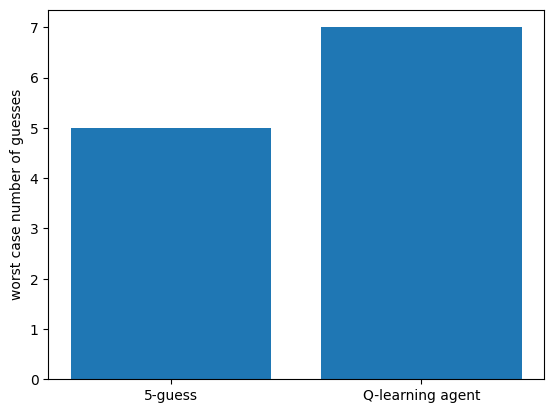

In [25]:
import matplotlib.pyplot as plt 
plt.bar(x=['5-guess','Q-learning agent'], height=[5,7])
_ = plt.ylabel('worst case number of guesses')

## Interpretation of results

Initially Q-learning algorithm was unstable without restricting the number of states based on the feedback obtained during the game. This is due to the dynamic environment in case of mastermind. The Environment, feedback and the reward depends on the random secret code selected at the start of the game.

But when state space is restricted State-values learnt by the Q-learning algorithm look to be stable. 

## Future directions

Q-learning:

1. Alternative representation of action. Action can be represented using different colors at the 4 positions based on the previous guesses and feedbacks.
2. Learn another Q-learning agent to select the secret code to make the learrning faster for the code breaking Q-learning agent.
3. Double Q_learning to reduce the maximisation bias and speed up Q-Learning.

Policy Gradient:

1. Parallelize the learning process and use GPU.
2. Use GRU instead of LSTM.


## References

1. https://github.com/egeromin/mastermind/
2. https://github.com/brianspiering/rl-course/tree/master/labs/lab_4_tic_tac_toe
3. https://ieeexplore.ieee.org/document/7926576
4. researchgate.net/publication/316947563_Playing_Mastermind_Game_by_Using_Reinforcement_Learning
1. https://en.wikipedia.org/wiki/Mastermind_(board_game)